<a href="https://colab.research.google.com/github/AugustinCablant/Stat-App/blob/main/MH_GIBBS_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#!pip install POT
#!pip install matplotlib
import ot
import numpy as np
import matplotlib.pyplot as plt

sigma=0.04
np.random.seed(123)

def log_proba_rejet(u,v,W,x,y,Z,T):
    u1,v1,W1 = histogramme(u),histogramme(v),histogramme(W)
    x1,y1,Z1 = histogramme(x),histogramme(y),histogramme(Z)
    return 1/(2*sigma**2)*(np.linalg.norm(T-ot.emd(u1,v1,W1))**2-np.linalg.norm(T-ot.emd(x1,y1,Z1))**2)

def in_hypercube(u,v,W):

    if any(x < 0 or x > 1 for x in u):
        return False

    if any(x < 0 or x > 1 for x in v):
        return False

    if any(any(x < 0 or x > 1 for x in row) for row in W):
        return False
    return True

def histogramme(x):
    # Normaliser la liste pour que la somme soit égale à 1
    somme = np.sum(x)
    histogramme = x / somme
    return histogramme

n = 10**5
def MH_gibbs(T):
    N = len(T)
    # Initialisation
    U, V, C = np.zeros((n, N)), np.zeros((n, N)), np.zeros((n, N, N))
    U[0] = np.random.uniform(size=N)
    V[0] = np.random.uniform(size=N)
    C[0, :, :] = np.random.uniform(size=(N, N))
    # Vecteurs aléatoires
    e_u, e_v,e_C  = np.random.normal(0, 0.075, (N, n)), np.random.normal(0, 0.035, (N, n)), np.random.normal(0, 0.04, (N, N, n))
    u_u, u_v, u_c  = np.log(np.random.uniform(size=n)), np.log(np.random.uniform(size=n)), np.log(np.random.uniform(size=n))

    acceptance_rate_u = 0
    acceptance_rate_v=0
    acceptance_rate_C=0

    running_average_U = [U[0]]
    running_average_V = [V[0]]
    running_average_C = [C[0]]

    for k in range(n-1):
        # Pas pour U
        x, y, Z = U[k] + e_u[:, k], V[k], C[k]
        if not in_hypercube(x, y, Z): U[k+1], V[k+1], C[k+1] = U[k], V[k], C[k]
        else:
            if u_u[k] < log_proba_rejet(U[k], V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate_u += 1
            else: U[k+1], V[k+1], C[k+1] = U[k], V[k], C[k]
        UK=U[k+1]
        # Pas pour V
        x, y, Z = UK, V[k] + e_v[:, k], C[k]
        if not in_hypercube(x, y, Z): U[k+1], V[k+1], C[k+1] = UK, V[k], C[k]
        else:
            if u_v[k] < log_proba_rejet(UK, V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate_v += 1
            else: U[k+1], V[k+1], C[k+1] = UK, V[k], C[k]
        VK=V[k+1]
        # Pas pour C
        x, y, Z = UK, VK, C[k] + e_C[:, :, k]
        if not in_hypercube(x, y, Z):
            U[k+1], V[k+1], C[k+1] = UK, VK, C[k]
        else:
            if u_c[k] < log_proba_rejet(U[k], V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate_C += 1
            else: U[k+1], V[k+1], C[k+1] = UK, VK, C[k]

        # Calcul du running average
        running_average_U.append((U[k+1]+U[k])*(k/(k+1)))
        running_average_V.append((V[k+1]+V[k])*(k/(k+1)))
        running_average_C.append((C[k+1]+C[k])*(k/(k+1)))

    acceptance_rate_u /= n
    acceptance_rate_v /= n
    acceptance_rate_C /= n
    return U, V, C, acceptance_rate_u,acceptance_rate_v,acceptance_rate_C, running_average_U,running_average_V,running_average_C

In [6]:
def f(C):
    a=len(C)
    D=np.zeros((a,a))
    for i in range(a):
        for j in range(a):
            D[i,j]=C[i,j]+C[1,1]-C[1,j]-C[i,1]
    return D

In [7]:
np.random.seed(123)
T = np.random.uniform(size=(5, 5))

# Simulation
U, V, C, acceptance_rate_u,acceptance_rate_v,acceptance_rate_C, running_average_U,running_average_V,running_average_C = MH_gibbs(T)

for k in range(n):
    U[k],V[k]=histogramme(U[k]),histogramme(V[k])
for k in range(n):
    C[k:,:,:][0]=f(C[k:,:,:][0])


print(f"Taux d'acceptation pour U : {acceptance_rate_u}")
print(f"Taux d'acceptation pour V : {acceptance_rate_v}")
print(f"Taux d'acceptation pour C : {acceptance_rate_C}")

Taux d'acceptation pour U : 0.25681
Taux d'acceptation pour V : 0.23851
Taux d'acceptation pour C : 0.25979


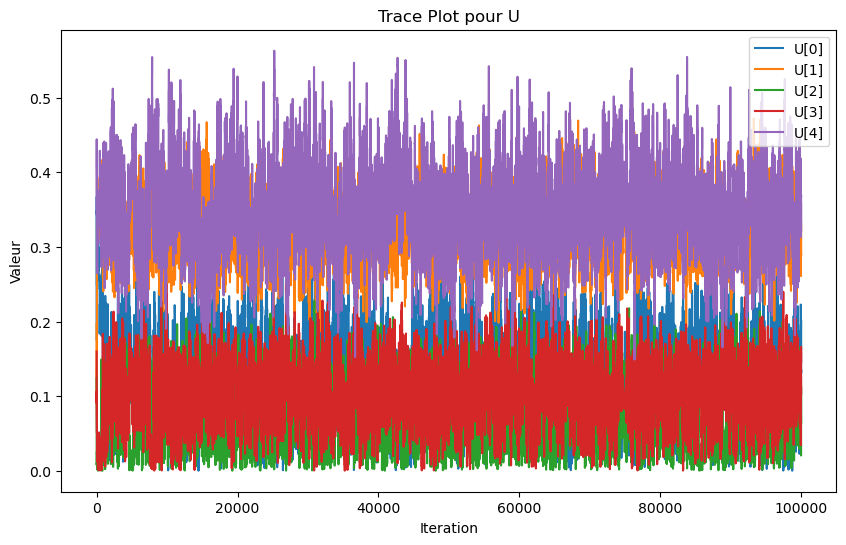

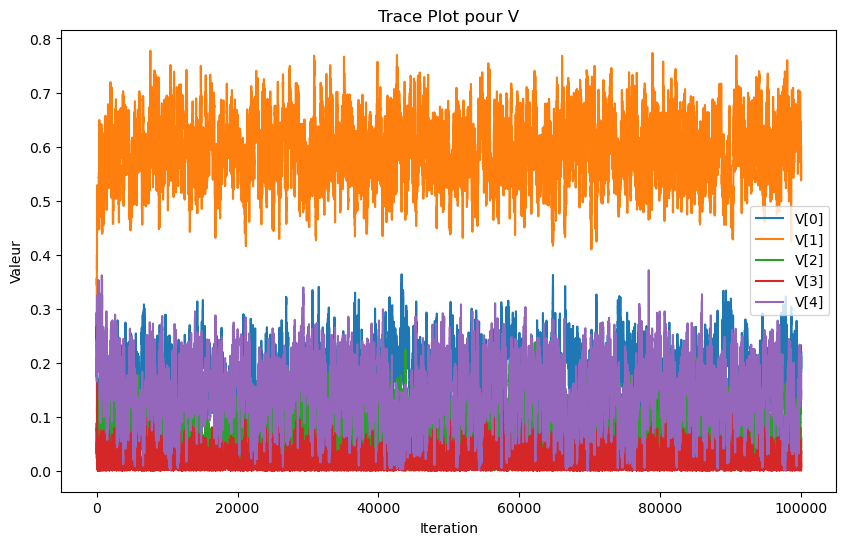

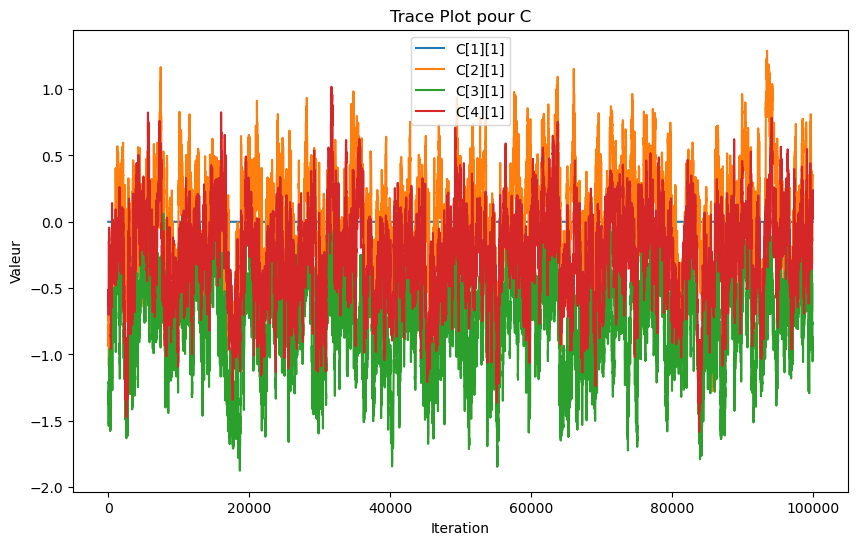

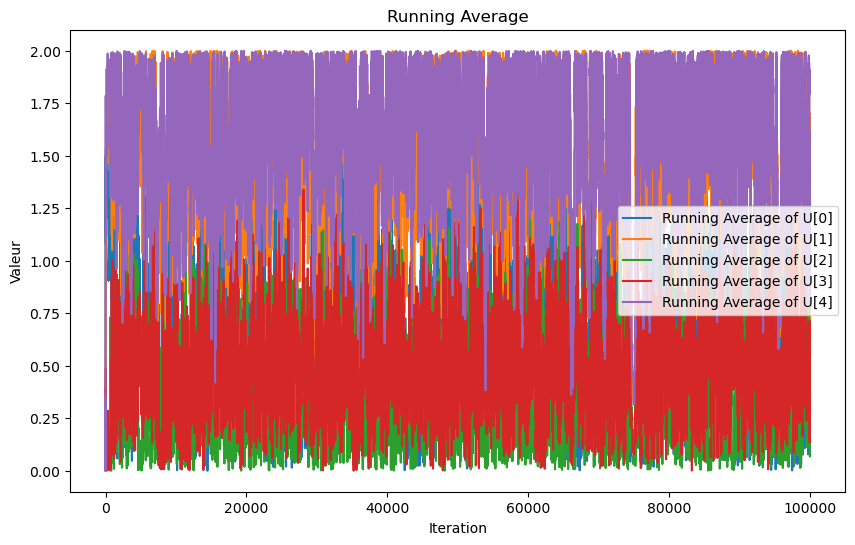

In [8]:
# Trace plot pour U
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(U[:, i], label=f"U[{i}]")
plt.title("Trace Plot pour U")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

# Trace plot pour V
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(V[:, i], label=f"V[{i}]")
plt.title("Trace Plot pour V")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(1,len(C[0])):
    plt.plot(C[:, i, 0], label=f"C[{i}][{1}]")
plt.title("Trace Plot pour C")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(list(range(len(running_average_U))), [sample[i] for sample in running_average_U], label=f'Running Average of U[{i}]')
plt.title("Running Average")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

### Evaluation du résultat

In [10]:
# Initialisation des données
np.random.seed(123)
u = np.array([0.1, 0.4, 0.5])
v = np.array([0.6, 0.35, 0.05])
C = np.array([[10, 0.25, 0.75], [0.83333333, 10, 0.16666667], [0.1, 0.9, 10]])

# Calcul du transport optimal 
T = ot.emd(u, v, C)

# Ajout de bruit gaussien à T
noise = np.random.normal(loc=0, scale=0.2, size=T.shape)
T_with_noise = T + noise

# Appel de MH_gibbs et sélection de la quatrième colonne
result = MH_gibbs(T_with_noise)
U, V, W = result[0], result[1], result[2]

# Calcul de la moyenne des matrices W avec contrainte
moyenne_W_contrainte = np.mean(W[1000:, :, :], axis=0)

# Application de f à C et à la moyenne des matrices W
C_applique = f(C)
moyenne_W_contrainte_applique = f(moyenne_W_contrainte)

print("C après application de f :")
print(C_applique)

print("Moyenne des matrices W avec contrainte après application de f :")
print(moyenne_W_contrainte_applique)

C après application de f :
[[1.89166667e+01 0.00000000e+00 1.03333333e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.36666667e+00 3.33066907e-16 1.89333333e+01]]
Moyenne des matrices W avec contrainte après application de f :
[[ 6.22011387e-01 -1.11022302e-16  6.74174621e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.88299057e-01  0.00000000e+00  2.85540965e-01]]


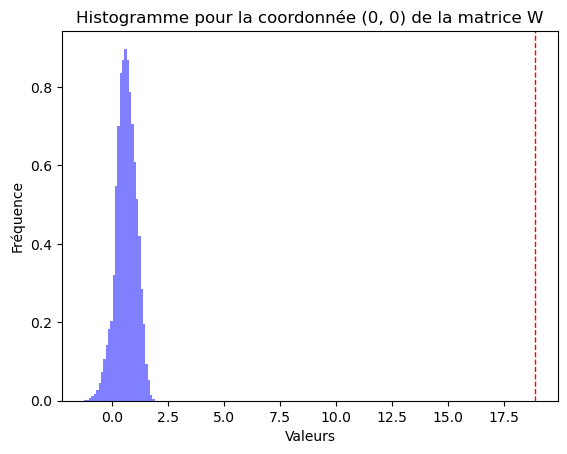

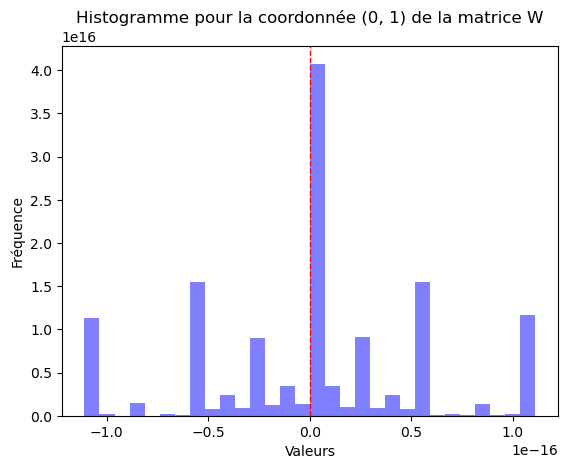

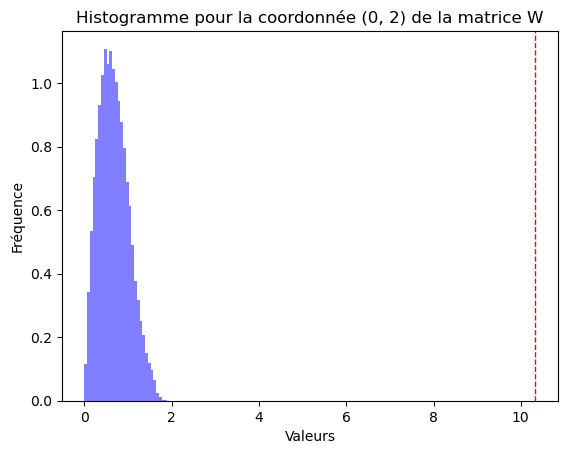

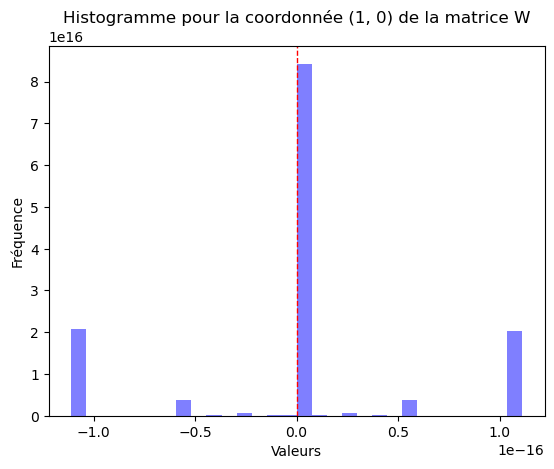

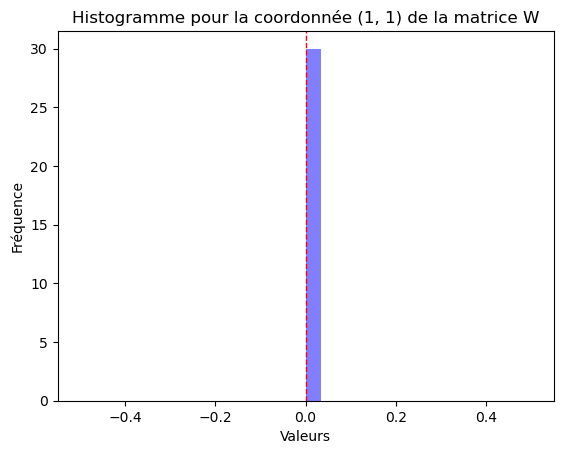

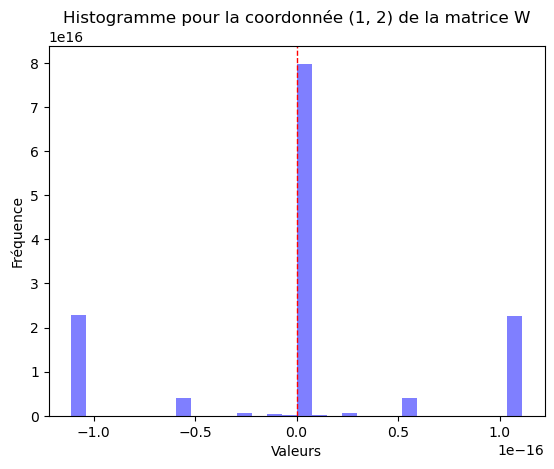

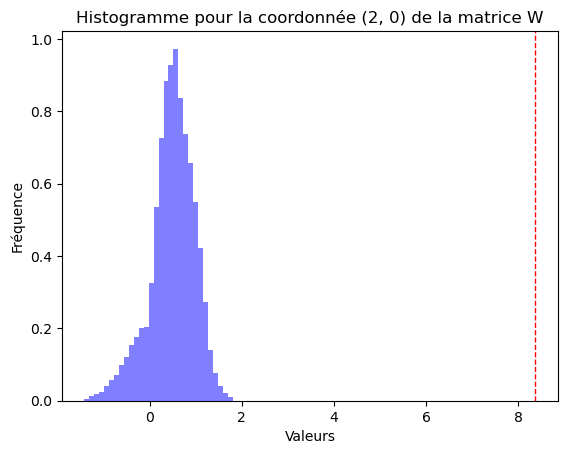

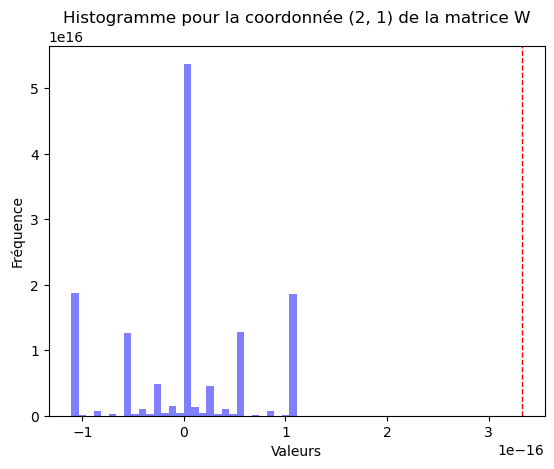

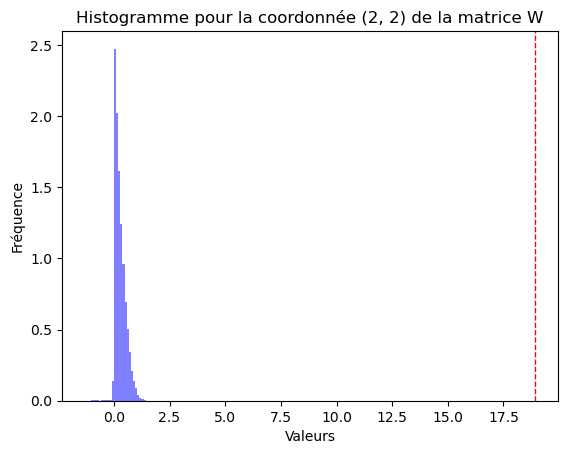

In [13]:
# Application de f à chaque matrice de W
W_applique = np.array([f(W[i, :, :]) for i in range(W.shape[0])])

# Affichage de l'histogramme pour chaque coordonnée de la matrice W avec C_appliqué comme axe vertical
for i in range(W_applique.shape[1]):
    for j in range(W_applique.shape[2]):
        plt.hist(W_applique[:, i, j], bins=30, color='blue', alpha=0.5, density=True)
        plt.axvline(x=C_applique[i, j], color='red', linestyle='--', linewidth=1)
        plt.title(f"Histogramme pour la coordonnée ({i}, {j}) de la matrice W")
        plt.xlabel("Valeurs")
        plt.ylabel("Fréquence")
        plt.show()